## Logistic Regression on a customer churn data set- telecoms subs

In [1]:
import pandas as pd
import numpy as np

# import plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# import sklearn libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix 
from sklearn.model_selection import train_test_split

### Load Data 

In [2]:
churnData = pd.read_csv('customer_churn.csv') 
churnData.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Business question 

Can we predict if a customer account will churn ? 

- classification ML problem
- we will feed in training data which is labeled churn yes or no
- model is logistic regression

### Normal intermediate steps 

we are skipping these steps of the process to focus on the data imbalance alone 

+ EDA 

+ Data cleaning 

+ Feature selection and engineering 

we will attempt to predict churn using just a few numerical features, and see what the baseline model gives us in terms of accuracy in class predictions

### Separate the dependent and independent variables 

In [3]:
X = churnData[['tenure', 'SeniorCitizen','MonthlyCharges']]
y = (churnData.Churn == 'Yes').astype(int) # turns churn into 1 or 0

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7043 non-null   int64  
 1   SeniorCitizen   7043 non-null   int64  
 2   MonthlyCharges  7043 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 165.2 KB


### Scale the numerical data 

In [5]:
transformer = StandardScaler().fit(X)
scaled_x = transformer.transform(X)

In [6]:
scaled_x

array([[-1.27744458, -0.43991649, -1.16032292],
       [ 0.06632742, -0.43991649, -0.25962894],
       [-1.23672422, -0.43991649, -0.36266036],
       ...,
       [-0.87024095, -0.43991649, -1.1686319 ],
       [-1.15528349,  2.27315869,  0.32033821],
       [ 1.36937906, -0.43991649,  1.35896134]])

### Confirm the imbalance in our target label 

In [7]:
y.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

https://www.kdnuggets.com/2020/01/5-most-useful-techniques-handle-imbalanced-datasets.html

### Modeling including model validation with train-test-split

In [8]:
# train test split 
X_train, X_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.3, random_state=100)

In [9]:
# define and train a LogisticRegression model
classification = LogisticRegression(random_state=0, solver='lbfgs',
                        multi_class='ovr').fit(X_train, y_train)

# creating predictions based on our trained model
y_pred=classification.predict(X_test)

### Evaluate the baseline model with confusion matrix 

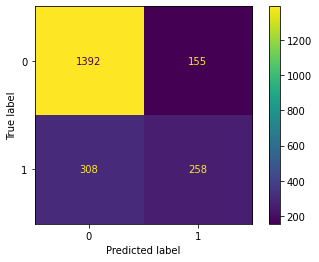

In [10]:
# confusion matrix 
# top left True Pos
# bottom right True Neg
# bottom left False Pos
# top right False Neg

confusion_matrix(y_test, y_pred)
plot_confusion_matrix(classification,X_test, y_test)
plt.show()

Observation: It's evident that our model is way better in predicting the `Churn=False` customers correctly than the ones that have churned - because of the heavy misbalance within the target variable of `5174` (Did not churn) to `1869` (have churned)

In [12]:
classification.score(scaled_x, y)

0.7905721993468693

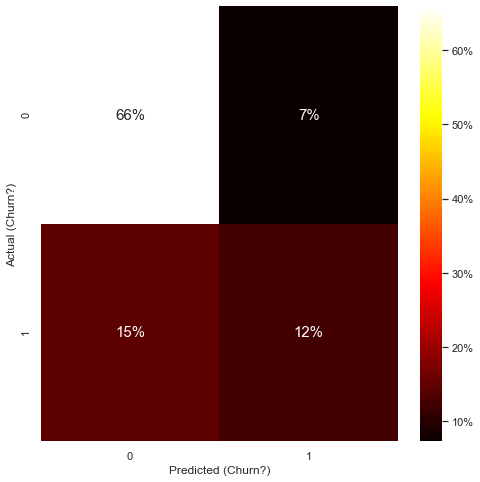

In [13]:
# % confusion matrix heat map

# shortened name
cnfmat = confusion_matrix(y_test, y_pred)

# creating a Dataframe out of our confusion matrix, easier to plot in seaborn. 
df_cm = pd.DataFrame(cnfmat, columns=np.unique(y_test), index = np.unique(y_test))

# column and index names to our df
df_cm.index.name = 'Actual (Churn?)'
df_cm.columns.name = 'Predicted (Churn?)'

# set the fontsize for my plot
sns.set(font_scale=1)

# set plot size
fig, ax = plt.subplots(figsize=(8,8))

# this function formatter is necessary to create a custom function which formats our values as % 
from matplotlib.ticker import FuncFormatter
fmt = lambda x,pos: '{:.0%}'.format(x)

# plot the heatmap for our confusion matrix
sns.heatmap(df_cm/df_cm.sum().sum(),  # plot the number of values as percentage of all values in the confusion matrix
            annot=True,
            fmt='.0%',
            cmap='hot',
            annot_kws={"size":15},
            cbar_kws={'format': FuncFormatter(fmt)}
           );

### applying SMOTE - (oversample the minority class of the target label)

In [23]:
from imblearn.over_sampling import SMOTE 

In [24]:
smote = SMOTE(random_state=40)
X_sm, y_sm = smote.fit_resample(scaled_x, y)

In [25]:
y_sm.value_counts()

0    5174
1    5174
Name: Churn, dtype: int64

### Model again and plot the confusion matrix (same code as above)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=100)

In [27]:
# define and train a LogisticRegression model
classification = LogisticRegression(random_state=0, solver='lbfgs',
                        multi_class='ovr').fit(X_train, y_train)

# creating predictions based on our trained model
y_pred=classification.predict(X_test)

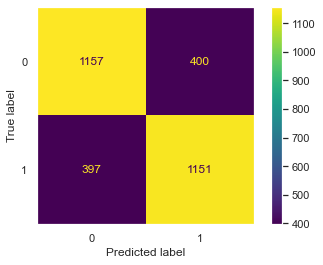

In [31]:
confusion_matrix(y_test, y_pred)
plot_confusion_matrix(classification,X_test, y_test)
plt.grid(None)
plt.show()

Observation

- 
- 
- 


### Applying TomekLinks to downsample majority class 

Observation:

- 
- 
- 


### which method to use ? 

* if you're unsure which method to use then, give [this article](https://machinelearningmastery.com/data-sampling-methods-for-imbalanced-classification/) a read. 
* In practice it was shown that combining several sampling techniques often yields the bet result so you can also explore hybrid methods in [this article](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/) to try to improve on the SMOTE result in this notebook